<a href="https://colab.research.google.com/github/Byeon-MJ/DL_Practice_Repo/blob/main/Recurrent_Neural_Network_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 순환 신경망으로 IMDB 리뷰 분류하기

## 순차 데이터
* 텍스트나 시계열 데이터와 같이 순서에 의미가 있는 데이터

## 순환 신경망
* 앞의 입력으로 나온 출력이 다시 입력으로 사용
* 이전 입력에 대한 기억이 어느정도 포함되어 있다.
* 타임 스텝 : 샘플을 처리하는 한 단계
* 셀 : 레이어의 개념
* 은닉 상태 : 셀의 출력
* RNN 에서는 활성화 함수로 tanh 를 많이 사용한다.

## IMDB 리뷰 데이터셋
* 유명한 인터넷 영화 데이터베이스 imdb.com에서 수집한 리뷰를 감상평에 따라 긍정과 부정으로 분류해 놓은 데이터셋
* 토큰화 된 데이터셋, 1개의 토큰이 하나의 타임스텝으로 사용
* 토큰 중 몇 개는 특정한 용도로 예약되는 경우가 많다. : 0(패딩), 1(문장 시작), 2(어휘 사전에 없는 토큰) 등

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import imdb
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

17464789/17464789 [==============================] - 1s 0us/step


In [2]:
# 개별 리뷰를 담은 파이썬 리스트 객체로 이루어진 넘파이 배열
print(train_input.shape, test_input.shape)

(25000,) (25000,)


In [3]:
print(len(train_input[0]))

218


In [4]:
print(len(train_input[1]))

189


In [5]:
# 첫번째 리뷰에 담긴 내용 > 토큰화 되어있다.
# 단어를 500개로 제한해서 어휘사전에 없는 단어는 모두 2로 표시됨
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [6]:
# 긍정 : 1, 부정 : 0
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [7]:
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42
)

### 훈련 세트 EDA

In [8]:
# 리뷰의 길이 계산하기
import numpy as np
lengths = np.array([len(x) for x in train_input])

In [9]:
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


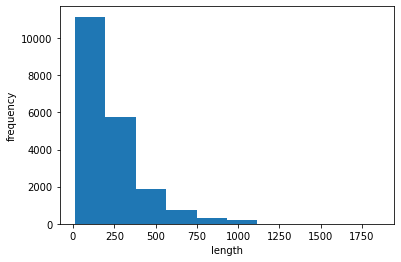

In [10]:
import matplotlib.pyplot as plt
plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

In [11]:
# 시퀀스 데이터 길이를 맞추는 pad_sequences() 함수 사용, train_input 길이 100으로 맞추기
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)      # maxlen 보다 긴 시퀀스의 앞부분을 자른다.
                                                        # 뒷부분을 자르고 싶다면 truncating 매개변수의 값을 'post'로 변경

In [12]:
print(train_seq.shape)

(20000, 100)


In [13]:
print(train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [14]:
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


In [15]:
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


In [16]:
val_seq = pad_sequences(val_input, maxlen=100)

## 순환 신경망 만들기 

In [18]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [19]:
# to_categorical() : 원-핫 인코딩된 배열 반환
train_oh = keras.utils.to_categorical(train_seq)

In [20]:
print(train_oh.shape)

(20000, 100, 500)


In [21]:
# 원-핫 인코딩 확인
print(train_oh[0][0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [22]:
print(np.sum(train_oh[0][0]))

1.0


In [23]:
# val_seq도 원-핫 인코딩
val_oh = keras.utils.to_categorical(val_seq)

In [24]:
# 모델 구조 출력
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 8)                 4072      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


## 순환 신경망 훈련하기

In [25]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 27s 72ms/step - loss: 0.6980 - accuracy: 0.5027 - val_loss: 0.6970 - val_accuracy: 0.5044
Epoch 2/100
313/313 [==============================] - 21s 68ms/step - loss: 0.6949 - accuracy: 0.5120 - val_loss: 0.6951 - val_accuracy: 0.5108
Epoch 3/100
313/313 [==============================] - 21s 68ms/step - loss: 0.6922 - accuracy: 0.5217 - val_loss: 0.6928 - val_accuracy: 0.5226
Epoch 4/100
313/313 [==============================] - 23s 72ms/step - loss: 0.6885 - accuracy: 0.5444 - val_loss: 0.6873 - val_accuracy: 0.5540
Epoch 5/100
313/313 [==============================] - 20s 65ms/step - loss: 0.6806 - accuracy: 0.5918 - val_loss: 0.6776 - val_accuracy: 0.5990
Epoch 6/100
313/313 [==============================] - 21s 66ms/step - loss: 0.6711 - accuracy: 0.6234 - val_loss: 0.6690 - val_accuracy: 0.6244
Epoch 7/100
313/313 [==============================] - 21s 67ms/step - loss: 0.6613 - accuracy: 0.6437 - val_loss: 0.6586 - val_ac

In [ ]:
# 훈련 손실과 검증 손실 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
print(train_seq.nbytes, train_oh.nbytes)

## 단어 임베딩을 사용하기
* 케라스의 keras.layers 패키지 아래 Embedding 클래스로 임베딩 기능 제공
* 단어 임베딩을 사용하면 메모리를 훨씬 효율적으로 사용할 수 있다.

In [26]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [27]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


In [29]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 31s 94ms/step - loss: 0.6715 - accuracy: 0.5778 - val_loss: 0.6379 - val_accuracy: 0.6556
Epoch 2/100
313/313 [==============================] - 28s 90ms/step - loss: 0.6088 - accuracy: 0.6989 - val_loss: 0.5937 - val_accuracy: 0.7134
Epoch 3/100
313/313 [==============================] - 28s 88ms/step - loss: 0.5759 - accuracy: 0.7350 - val_loss: 0.5718 - val_accuracy: 0.7354
Epoch 4/100
313/313 [==============================] - 28s 89ms/step - loss: 0.5547 - accuracy: 0.7552 - val_loss: 0.5583 - val_accuracy: 0.7408
Epoch 5/100
106/313 [=========>....................] - ETA: 17s - loss: 0.5404 - accuracy: 0.7661

KeyboardInterrupt: ignored

In [ ]:
# 훈련 손실과 검증 손실 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()